# Code examples for complex figures AND the iterative method for fitting with uncertainties in x and y

This notebook first loads a data file `LightIntensityData.csv` and demonstrates a nonlinear fit on it, and then subsequently shows multiple examples of complex figures that could be plotted based on the data, fit and residuals

## Loading the data

First load relevant libraries, the data and the fitting function.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Definition of the fit function
#   The model is an inverse-square law with correction for near-field effects
#   k: the overall light intensity
#   L: the estimate of the length of the filament in metres.
def fit_function(x, k, L):
    return 2*k/L/x*np.arctan(L/(2*x))

def fit_dydx(x, k, L):
    # Used Wolfram alpha to differentiate the function above
    return k*(-4/(x*(L**2+4*x**2))-(2*np.arctan(L/(2*x)))/(L*x**2))

# Load the data
#   fname is assumed to be a .csv file (comma separated values). All rows 
#   containing non-number text (example: names for each column) must begin 
#   with "#". 
fname = 'LightIntensityData.csv'

# The data file fname has x data (first column) and y data (third column) and 
# the uncertianty in x and y (second and fourth column).
# Enter the name and units of each column here so that the plots are properly
x_name = 'Distance'
x_units = 'metres'
y_name = 'Intensity'
y_units = 'Watts/m^2'

# load the file "fname", defined above
data = np.loadtxt(fname, delimiter=',', comments='#',usecols=(0,1,2,3))

# Access the data columns and assign variables x,y  and  y_sigma
x = data[:,0]
y = data[:,2]
x_sigma = data[:,1]
y_sigma = data[:,3]

# Fitting the data: first using only uncertainties in y, and then using uncertainties in x and y

### Visualize the data to inform reasonable initital guesses for the fitting parameters

We make an initial plot of the data so that we can make reasonable initital guesses for the fitting parameters. We include a log-log scale plot since we are expecting the overall behaviour to be be similar to a power law (inverse-square law), with corrections

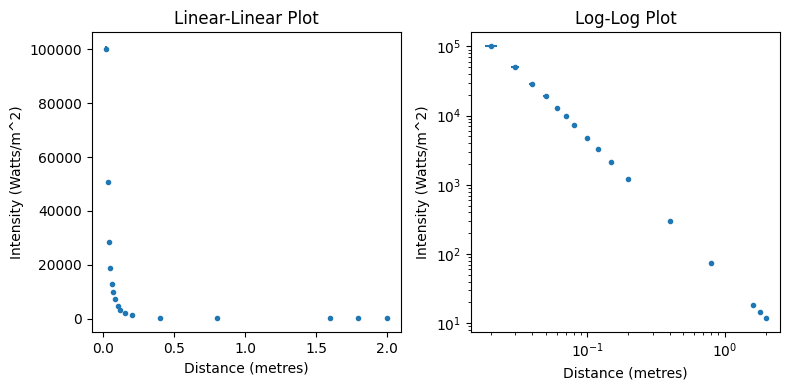

In [2]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Linear-Linear Plot
axes[0].errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='')
axes[0].set_xlabel(f'{x_name} ({x_units})')
axes[0].set_ylabel(f'{y_name} ({y_units})')
axes[0].set_title('Linear-Linear Plot')

# Log-Log Plot
axes[1].errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel(f'{x_name} ({x_units})')
axes[1].set_ylabel(f'{y_name} ({y_units})')
axes[1].set_title('Log-Log Plot')

# Adjust layout and show
plt.tight_layout()
plt.show()

As expected, the Log-Log plot looks somewhat linear. See the next section for a discussion of guessing the initial fitting parameters

### Make some initial guesses for the fitting parameters

Most of us have minimal intuition around how the model parameters $k$ and $L$ influence the following equation

$$\dfrac{2k}{Lx} \arctan(\dfrac{L}{2x}).$$

We first remind ourselves of the descriptions of the model parameters from the initial code box:
* $k$: the overall light intensity in Watts
* $L$: the estimate of the length of the filament in metres.

Based on these desriptions, let's use some typical values for incandescent light bulbs: 30 W, 60 W and 100 W and visualize those.

Given that $L$ represents a filament length in meters, let's visualize what happens for $L$ = 0.01 m, 0.05 m and 0.1 m.

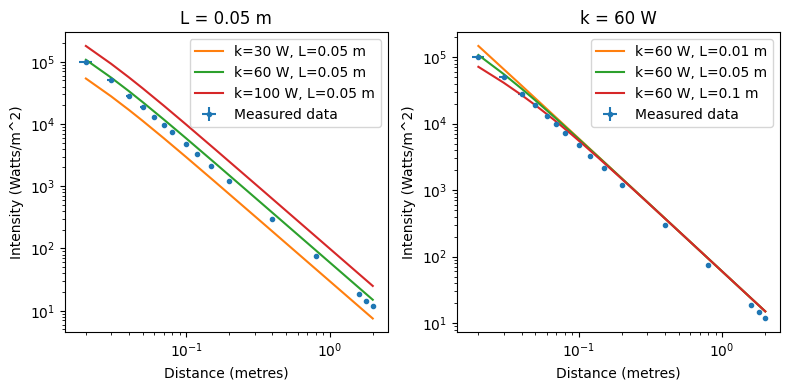

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Initial x-values for plotting
x_model = np.linspace(min(x), max(x), 200)

# Define guesses for k and l
k_fixed = 60
k_values = [30, 60, 100]
L_fixed = 0.05
L_values = [0.01, 0.05, 0.1]

# Left plot: L is fixed, k varies
ax = axes[0]
ax.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
L = L_fixed
for k in k_values:
    y_model = fit_function(x_model, k, L)
    ax.plot(x_model, y_model, label=f'k={k} W, L={L} m')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'{x_name} ({x_units})')
ax.set_ylabel(f'{y_name} ({y_units})')
ax.set_title(f'L = {L} m')
ax.legend()

# Right plot: L is fixed, k varies
ax = axes[1]
ax.errorbar(x, y, xerr=x_sigma, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
k = k_fixed
for L in L_values:
    y_model = fit_function(x_model, k, L)
    ax.plot(x_model, y_model, label=f'k={k} W, L={L} m')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'{x_name} ({x_units})')
ax.set_ylabel(f'{y_name} ({y_units})')
ax.set_title(f'k = {k_fixed} W')
ax.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()

Based on the above, it looks like it is reasonable to start with initial guesses of k = 60 W and L = 0.05 m for our fitting.

### Performing a regular fit using uncertainties in y

Based on the above, we now have some initial guesses for our fitting parameters and can proceed with performing a fit using out uncertainties in y. We will loop back and look at how to included uncertainties in x afterward.

In [4]:
# This fit uses only the y-uncertainties, not the x-uncertainties

k_guess = 60 # W
L_guess = 0.05 # L
guesses = (k_guess, L_guess)

# We will use sigma_tot for the overall representation of uncertainties later
# so will introduce that here

sigma_tot = y_sigma

###############################################################################
# Perform the fit
###############################################################################
                    
# Fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params, fit_cov = curve_fit(fit_function, x, y, 
    sigma=sigma_tot, p0=guesses, absolute_sigma=True, maxfev=10**5)
                            
###############################################################################
# Output chi-squared
###############################################################################

# Function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_parameters)
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)/dof
    
# Calculate and print chi squared
chi2 = chi_square(fit_params,x,y,sigma_tot)
print ("Goodness of fit - reduced chi-squared:")
print (f"  Chi2 = {chi2:.3}")


###############################################################################
# Output fit parameters (with uncertainty)
###############################################################################

# Calculate the standard deviation as uncertainty of the fit parametersc
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['Intensity of the lamp','Length of the filament']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print (f"  {param_names[i]} = {fit_params[i]:.5} ± {fit_params_error[i]:.2}")

Goodness of fit - reduced chi-squared:
  Chi2 = 10.8
Fit parameters:
  Intensity of the lamp = 47.824 ± 0.026
  Length of the filament = 0.030575 ± 0.00088


#### *Plotting the results*

Here we plot our results with the model, with a regular residuals graph, and then introduce a new kind of residuals graph which is standardized residuals. Because our uncertainties in y vary over many orders of magnitude, our regular residuals graph only provides clear insight when the these y-uncertainties are large. 

The **standardized residuals** are simply the residuals divided by their own uncertainty, such that every residual is in units of uncertainty. As such, a standardized residual of 1 means that the data point is one sigma away from the model prediction, 2 means that it is two sigma away, and so on.

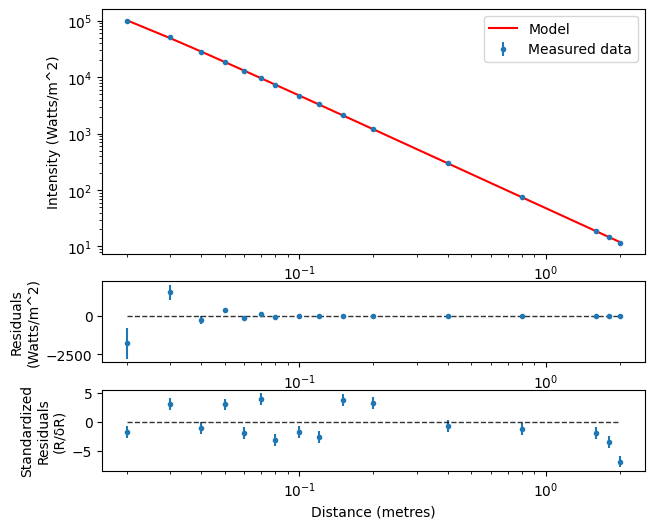

In [5]:
### Sets up a figure with three parts stacked vertically

# For them to be equal height
# fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 6))

# For them to have 2:1 height ratios
fig, ax = plt.subplots(3, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1, 1]})

# The final values for y_model using the most recent fit_params
y_model = fit_function(x_model, *fit_params)

# The residuals using the most recent fit_paramsa
residual = y - fit_function(x, *fit_params)

# The first subplot: plot of data and a fit finction
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle="--")
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals\n({y_units})')
ax[1].set_xscale('log')

# The third subplot: standardized residuals
ax[2].errorbar(x, residual/sigma_tot, yerr=1,marker='.',linestyle='')
ax[2].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle="--")
ax[2].set_xlabel(f'{x_name} ({x_units})')
ax[2].set_ylabel(f'Standardized\nResiduals\n(R/δR)')
ax[2].set_xscale('log')

plt.savefig('graph1.png') # This will save a copy of the graph into your working directory
plt.show()

With the help of the standardized residuals we see that there is perhaps a small trend of the model values being a bit too high for the larger values of x, but that overall the scatter for most of the data look fairly random. As we will see below, this information from the residuals suggests strongly that out chi-squared of 10.8 is due to an underestimate of the uncertainties, which we are going to fix by incorportating the x-uncertainties into the fit as well.

### Introducing effective y-uncertainties so that we can incorporate x-uncertainties into the fit.

We will use the method of combining the x- and y- uncertainties into an overall effective y-uncertainty ($\sigma_{tot}$) for the purposes of fitting, which involves converting $\delta x$ into an effective $\delta y_{eff}$ using the local slope at that point (aka the derivative of the fit function):

$$\delta y_{eff} = \frac{df}{dx}\delta x.$$

Our overall y-uncertainty ($\sigma_{tot}$) is thus given by

$$\sigma_{tot} = \sqrt{\delta y^2 + \delta y^2_{eff} }.$$

Notice that these effective uncertainties are now dependent on $\frac{df}{dx}$ (which is the slope for a linear fit), such that you will need to use an iterative approach to ensure that the fitting parameters are allowed to converge to new values since changing the fitting uncertainty from $\delta y$ to $\sigma_{tot}$ will cause small changes in the fitting parameters.

#### *A first iteration using using $\sigma_{tot}$ in our fit*

In [6]:
# We use the previous fit parameters as our initial guesses
guesses = fit_params

# First get the slope at using the current parameter guesses
dydx = fit_dydx(x,*guesses)

# Overall uncertainty
sigma_tot = np.sqrt( y_sigma**2 + (dydx * x_sigma)**2 )

###############################################################################
# Perform the fit
###############################################################################
                    
# Fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params, fit_cov = curve_fit(fit_function, x, y, 
    sigma=sigma_tot, p0=guesses, absolute_sigma=True, maxfev=10**5)
                            
###############################################################################
# Output chi-squared
###############################################################################

# Function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_parameters)
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)/dof
    
# Calculate and print chi squared
chi2 = chi_square(fit_params,x,y,sigma_tot)
print ("Goodness of fit - reduced chi-squared:")
print (f"  Chi2 = {chi2:.3}")


###############################################################################
# Output fit parameters (with uncertainty)
###############################################################################

# Calculate the standard deviation as uncertainty of the fit parametersc
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['Intensity of the lamp','Length of the filament']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print (f"  {param_names[i]} = {fit_params[i]:.5} ± {fit_params_error[i]:.2}")

Goodness of fit - reduced chi-squared:
  Chi2 = 0.466
Fit parameters:
  Intensity of the lamp = 47.196 ± 0.11
  Length of the filament = 0.022048 ± 0.015


What we see is a significant improvement in chi-squared (10.8 to 0.47), not from a significantly better fit, but due to updating our uncertainties to properly account for x-uncertainties. The residuals in our original fit had good scatter, but as we noted previously looked like the uncertainties were underestimated. Increasing our overall uncertainties by incorporating the x-uncertainties as well brought us to a chi-squared that suggests a much better fit. 

Previous fit using only y-uncertainties.

* Intensity of the lamp = 47.824 ± 0.026
* Length of the filament = 0.030575 ± 0.00088

We see that the best-fit parameters have each changed noticeably, so we will re-run this previous step with these new best-fit parameters as initial guesses. Remember that $\sigma_{tot}$ uses our guesses to estimate $\delta y_{eff}$ so we use an iterative process to bring our guesses to be as close as possible to the best-fit parameters.

#### *A second iteration using using $\sigma_{tot}$ in our fit*

Fortunately because of the way we set up our code, each subsequent iteration can use the same code as the previous one because that stage's guesses for the fitting parameters are just `fitting parameters` from the previous step.

In [7]:
# We use the previous fit parameters as our initial guesses
guesses = fit_params

# First get the slope at using the current parameter guesses
dydx = fit_dydx(x,*guesses)

# Overall uncertainty
sigma_tot = np.sqrt( y_sigma**2 + (dydx * x_sigma)**2 )

###############################################################################
# Perform the fit
###############################################################################
                    
# Fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params, fit_cov = curve_fit(fit_function, x, y, 
    sigma=sigma_tot, p0=guesses, absolute_sigma=True, maxfev=10**5)
                            
###############################################################################
# Output chi-squared
###############################################################################

# Function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_parameters)
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)/dof
    
# Calculate and print chi squared
chi2 = chi_square(fit_params,x,y,sigma_tot)
print ("Goodness of fit - reduced chi-squared:")
print (f"  Chi2 = {chi2:.3}")


###############################################################################
# Output fit parameters (with uncertainty)
###############################################################################

# Calculate the standard deviation as uncertainty of the fit parametersc
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['Intensity of the lamp','Length of the filament']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print (f"  {param_names[i]} = {fit_params[i]:.5} ± {fit_params_error[i]:.2}")

Goodness of fit - reduced chi-squared:
  Chi2 = 0.471
Fit parameters:
  Intensity of the lamp = 47.196 ± 0.1
  Length of the filament = 0.021148 ± 0.017


It looks like $k$ has converged, but we should do at least one more iteration to ensure that $L$ converges.

* Intensity of the lamp (1st iteration) = 47.196 ± 0.11
* Length of the filament (1st iteration) = 0.022048 ± 0.015

#### *A third iteration using using $\sigma_{tot}$ in our fit*
Hopefully we will see that $L$ converges as well.

In [17]:
# We use the previous fit parameters as our initial guesses
guesses = fit_params

# First get the slope at using the current parameter guesses
dydx = fit_dydx(x,*guesses)

# Overall uncertainty
sigma_tot = np.sqrt( y_sigma**2 + (dydx * x_sigma)**2 )

###############################################################################
# Perform the fit
###############################################################################
                    
# Fit the data to fit_function. fit_params is the resultant parameters, fit_cov
# is the covariance matrix between all the parameters. maxfev=10**5 means the
# fitting procedure is iterated at maximum 10^5 times before giving up.
fit_params, fit_cov = curve_fit(fit_function, x, y, 
    sigma=sigma_tot, p0=guesses, absolute_sigma=True, maxfev=10**5)
                            
###############################################################################
# Output chi-squared
###############################################################################

# Function that  calculates the chi square value of a fit
def chi_square (fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_parameters)
    return np.sum((y-fit_function(x, *fit_parameters))**2/sigma**2)/dof
    
# Calculate and print chi squared
chi2 = chi_square(fit_params,x,y,sigma_tot)
print ("Goodness of fit - reduced chi-squared:")
print (f"  Chi2 = {chi2:.3}")


###############################################################################
# Output fit parameters (with uncertainty)
###############################################################################

# Calculate the standard deviation as uncertainty of the fit parametersc
fit_params_error = np.sqrt(np.diag(fit_cov))

# read out parameter results
param_names = ['Intensity of the lamp','Length of the filament']
print ("Fit parameters:")
for i in range(len(fit_params)):
    print (f"  {param_names[i]} = {fit_params[i]:.5} ± {fit_params_error[i]:.2}")

Goodness of fit - reduced chi-squared:
  Chi2 = 0.47
Fit parameters:
  Intensity of the lamp = 47.196 ± 0.1
  Length of the filament = 0.021043 ± 0.017


It looks like both fit parameters have now converged (the change in $L$ is now less than 1%). For comparison, the fit parameters from the previous iteration were)

* Intensity of the lamp (2nd iteration) = 47.196 ± 0.1
* Length of the filament (2nd iteration) = 0.021148 ± 0.017

#### *Plotting the results*

We now plot the results from converged to solution using $\sigma_{tot}$ for our uncertainty.

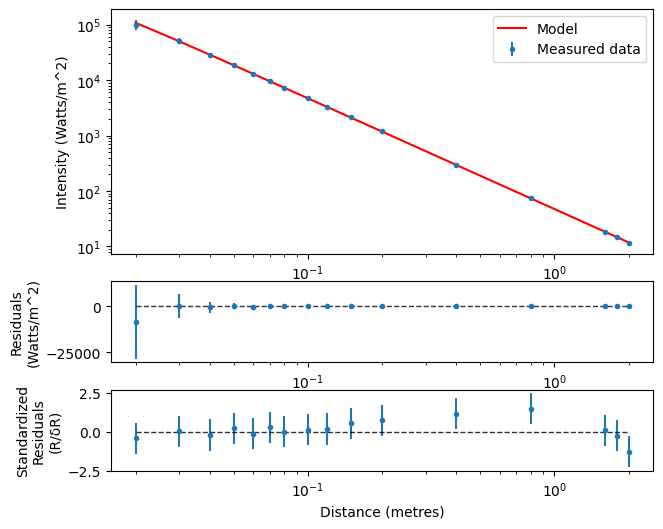

In [18]:
### Sets up a figure with three parts stacked vertically

# For them to be equal height
# fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 6))

# For them to have 2:1 height ratios
fig, ax = plt.subplots(3, 1, figsize=(7, 6), gridspec_kw={'height_ratios': [3, 1, 1]})

# The final values for y_model using the most recent fit_params
y_model = fit_function(x_model, *fit_params)

# The residuals using the most recent fit_paramsa
residual = y - fit_function(x, *fit_params)

# The first subplot: plot of data and a fit finction
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle="--")
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals\n({y_units})')
ax[1].set_xscale('log')

# The third subplot: standardized residuals
ax[2].errorbar(x, residual/sigma_tot, yerr=1,marker='.',linestyle='')
ax[2].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle="--")
ax[2].set_xlabel(f'{x_name} ({x_units})')
ax[2].set_ylabel(f'Standardized\nResiduals\n(R/δR)')
ax[2].set_xscale('log')

plt.savefig('graph1.png') # This will save a copy of the graph into your working directory
plt.show()

From our final iteration, we see that we have a reasonable, but perhaps not great fit. Our chi-squared is 0.47, but we can see that our standardized residuals have a prominent pattern where the model is overestimating intensity at the largest measured distances. Thus it looks like this value of chi-squared close to 1 is due to a combination of slightly overestimated uncertainties and a model that doesn't describe the data that well at larger distances.

Final results:
* Chi2 = 0.47
Fit parameters:
* Intensity of the lamp = 47.196 ± 0.1
* Length of the filament = 0.021043 ± 0.017

# Complex plots

The following shows a number of different complex plots that we can make using these data.

## 2-Panel plot using regular axes (linear-linear) and saving a graph

This code produces a two-part figure where the x-axis is shared. The code assumes you have defined many of the things defined above

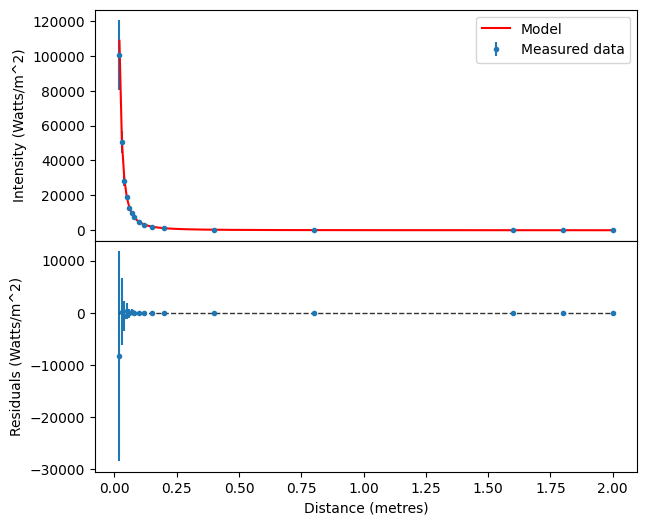

In [25]:
# Sets up a figure with two parts stacked vertically and shared x-axis scale 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))

# The first subplot: plot of data and a fit finction
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals ({y_units})')

plt.subplots_adjust(hspace=0) # Remove space between the subplots
plt.savefig('graph1.png') # This will save a copy of the graph into your working directory
plt.show()

## 2-Panel plot using log-log axes

This code produces a two-part figure where the x-axis is shared and log-log axes are used for the main plot. The code assumes you have defined many of the things defined above

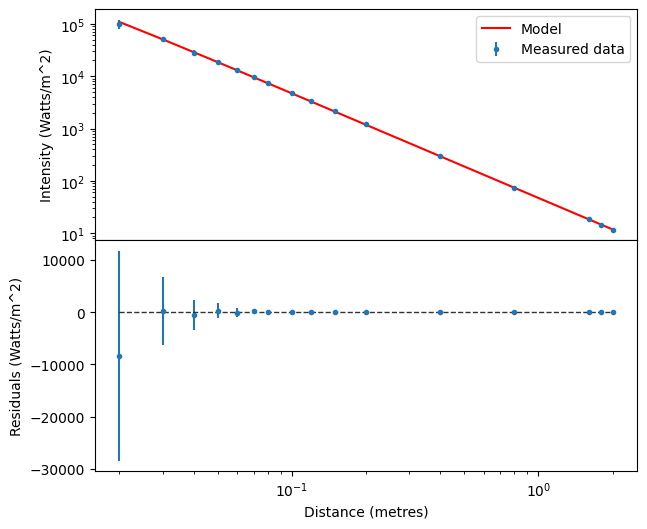

In [26]:
# Sets up a figure with two parts stacked vertically and shared x-axis scale 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))

# The first subplot: plot of data and a fit finction
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals ({y_units})')

plt.subplots_adjust(hspace=0) # Remove space between the subplots
plt.show()

## 2-Panel plot with inset

This code produces a two-part figure where the x-axis is shared and the first panel has an inset. 

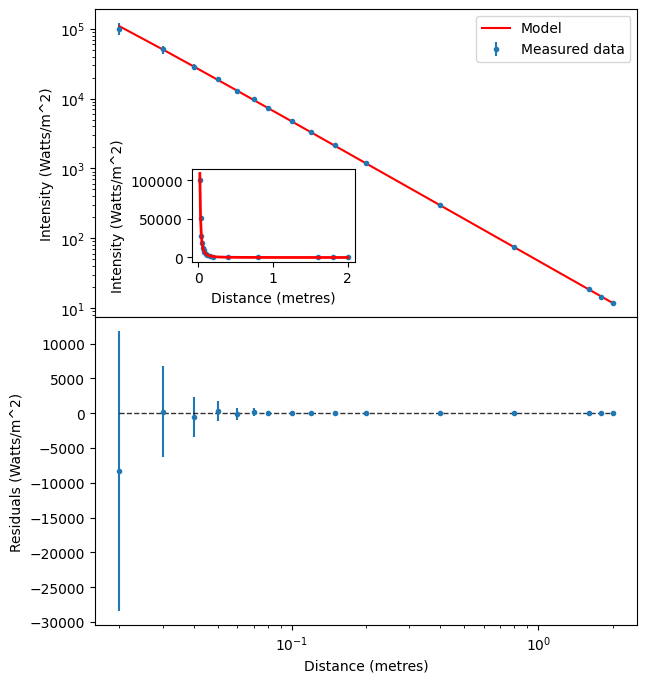

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition

# Sets up a figure with two parts stacked vertically and shared x-axis scale 
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 8))

# The first subplot: plot of data and a fit function
ax[0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0].plot(x_model, y_model, marker="", color="r", label="Model")
ax[0].set_ylabel(f'{y_name} ({y_units})')
ax[0].legend(loc='best')
ax[0].set_xscale('log')
ax[0].set_yscale('log')

# The second subplot: residuals
ax[1].errorbar(x, residual, yerr=sigma_tot, marker='.', linestyle='')
ax[1].hlines(0, np.min(x), np.max(x), lw=1, alpha=0.8, color="k", linestyle='--')
ax[1].set_xlabel(f'{x_name} ({x_units})')
ax[1].set_ylabel(f'Residuals ({y_units})')

# Create an inset Axes: this should fill the bounding box allocated to it.
inset = ax[0].inset_axes([0.18, 0.18, 0.30, 0.30])
inset.errorbar(x, y, yerr=y_sigma, marker='.', linestyle='', label="Measured data")
inset.errorbar(x_model, y_model, marker="", linestyle="-", linewidth=2, color="r", label="Fit")
inset.set_xlabel(f'{x_name} ({x_units})')
inset.set_ylabel(f'{y_name} ({y_units})')

plt.subplots_adjust(hspace=0) # Remove space between the subplots
plt.show()

## 4-Panel plot with shared x- and y-axes

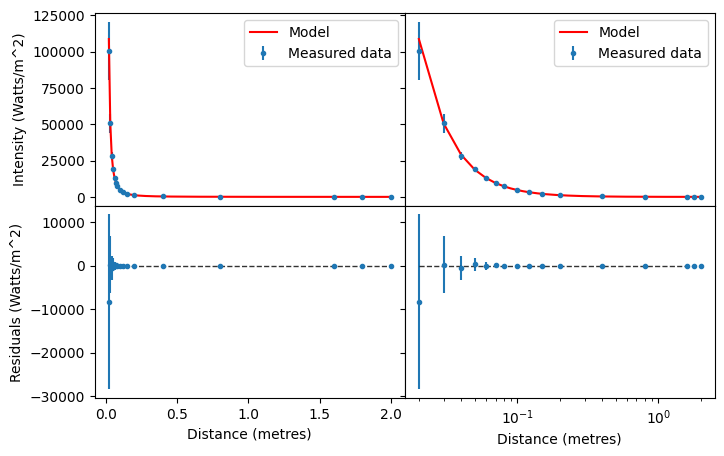

In [31]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, 2, hspace=0, wspace=0)
ax = gs.subplots(sharex='col', sharey='row')

# The upper-left subplot: plot of data and a fit finction
ax[0,0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,0].set_ylabel(f'{y_name} ({y_units})')
ax[0,0].legend(loc='best')

# The lower-left subplot: residuals
ax[1,0].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,0].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1,0].set_xlabel(f'{x_name} ({x_units})')
ax[1,0].set_ylabel(f'Residuals ({y_units})')

# The upper-right subplot: plot of data and a fit finction
ax[0,1].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,1].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,1].legend(loc='best')
ax[0,1].set_xscale('log')

# The lower-right subplot: residuals
ax[1,1].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1,1].set_xlabel(f'{x_name} ({x_units})')
ax[1,1].set_xscale('log')

plt.show()

## 4-Panel plot with independent y-axes and shared x-axes within column

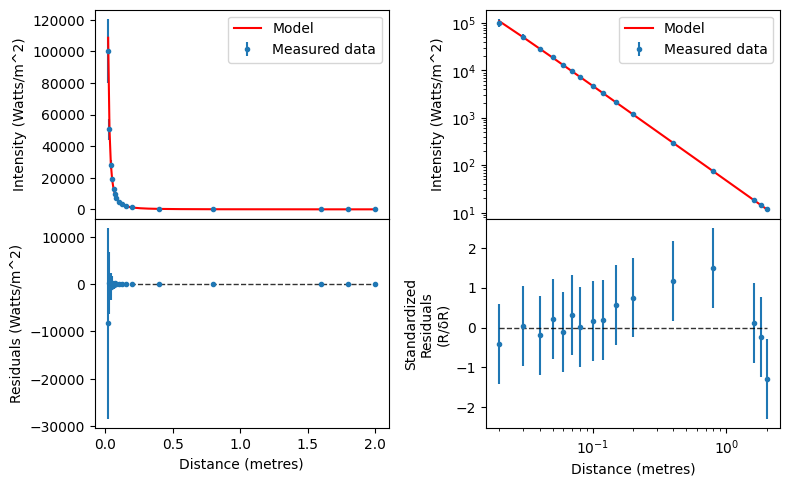

In [33]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 5))

# The upper-left subplot: plot of data and a fit finction
ax[0,0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,0].set_ylabel(f'{y_name} ({y_units})')
ax[0,0].legend(loc='best')

# The lower-left subplot: residuals
ax[1,0].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,0].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1,0].set_xlabel(f'{x_name} ({x_units})')
ax[1,0].set_ylabel(f'Residuals ({y_units})')

# The upper-right subplot: plot of data and a fit finction
ax[0,1].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,1].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,1].set_ylabel(f'{y_name} ({y_units})')
ax[0,1].legend(loc='best')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

# The lower-right subplot: standardized residuals
ax[1,1].errorbar(x, residual/sigma_tot, yerr=1,marker='.',linestyle='')
ax[1,1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1,1].set_xlabel(f'{x_name} ({x_units})')
ax[1,1].set_xscale('log')
ax[1,1].set_ylabel(f'Standardized\nResiduals\n(R/δR)')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.show()

## 4-Panel plot with independent axes

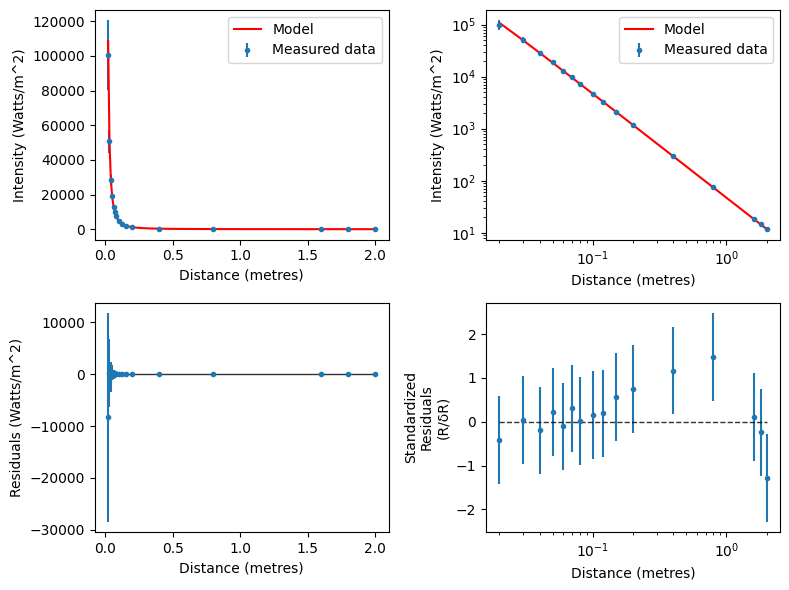

In [34]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# The upper-left subplot: plot of data and a fit finction
ax[0,0].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,0].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,0].set_xlabel(f'{x_name} ({x_units})')
ax[0,0].set_ylabel(f'{y_name} ({y_units})')
ax[0,0].legend(loc='best')

# The lower-left subplot: residuals
ax[1,0].errorbar(x, residual, yerr=sigma_tot,marker='.',linestyle='')
ax[1,0].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k")
ax[1,0].set_xlabel(f'{x_name} ({x_units})')
ax[1,0].set_ylabel(f'Residuals ({y_units})')

# The upper-right subplot: plot of data and a fit finction
ax[0,1].errorbar(x, y, yerr=sigma_tot, marker='.', linestyle='', label="Measured data")
ax[0,1].plot(x_model,y_model,marker="",color="r",label="Model")
ax[0,1].set_xlabel(f'{x_name} ({x_units})')
ax[0,1].set_ylabel(f'{y_name} ({y_units})')
ax[0,1].legend(loc='best')
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')

# The lower-right subplot: standardized residuals
ax[1,1].errorbar(x, residual/sigma_tot, yerr=1,marker='.',linestyle='')
ax[1,1].hlines(0,np.min(x),np.max(x),lw=1,alpha=0.8, color="k", linestyle='--')
ax[1,1].set_xlabel(f'{x_name} ({x_units})')
ax[1,1].set_xscale('log')
ax[1,1].set_ylabel(f'Standardized\nResiduals\n(R/δR)')

plt.tight_layout()
plt.show()